### Exponential Moving averages cross over using backtrader python library non nueral network approach

In [ ]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install empyrical


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39762 sha256=c6717ff853a39ed07b55b7eb817af3a3f9b10b775dede27e1b4d86caca5d8b12
  Stored in directory: /root/.cache/pip/wheels/0e/2e/f2/d6d2d9a1eb8fbbd9949bb5d4c00f753e3b74e5bd7ed10b1d36
Successfully built empyrical


### Download data and prepare

In [ ]:
# remove your installed pyfolio library
!pip uninstall -y pyfolio

# Install it again from its github repo
!pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-jj2qbmq8
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-jj2qbmq8
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.3 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75761 sha256=1f082ad28842ba4b58283c3bc3f302a6a638c9c8876d8c740831fbcba609035c
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8pk3xax/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
Successfully built pyfolio


In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insert the directory
# Right click on SwingTrader folder from shared files and select create short cut to add at My Drive
import sys
sys.path.insert(0,'/content/drive/My Drive/SwingTrader/')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Cerebro class is the cornerstone of backtrader bcause it serves as a central point for:

Gathering all inputs (Data Feeds), actors (Stratgegies), spectators (Observers), critics (Analyzers) and documenters (Writers) ensuring the show still goes on at any moment.

Execute the backtesting/or live data feeding/trading

Returning the results

Giving access to the plotting facilities

In [ ]:
'''
MovingAverageCrossStrategy, golden cross buy; dead cross sell Close position when opposite cross happens Negative return and sharp ratio.
'''
import os
import pandas as pd
from datetime import datetime
import backtrader as bt
# set browser full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

class MADoubleCross(bt.Strategy):
    params = (
        ('short_window', 20),
        ('long_window', 20),
        ('printlog', False),        # comma is required
    )

    def __init__(self):
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.bar_executed = None
        self.val_start = None
        self.dataclose = self.datas[0].close
        self.short_ema = bt.indicators.ExponentialMovingAverage(self.dataclose, period = self.params.short_window)
        self.long_ema = bt.indicators.ExponentialMovingAverage(self.dataclose, period = self.params.long_window)

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:                # order.Partial
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Size: %.0f, Cost: %.2f, Comm %.2f, RemSize: %.0f, RemCash: %.2f' %
                    (order.executed.price,
                     order.executed.size,
                     order.executed.value,
                     order.executed.comm,
                     order.executed.remsize,
                     self.broker.get_cash()))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Size: %.0f, Cost: %.2f, Comm %.2f, RemSize: %.0f, RemCash: %.2f' %
                         (order.executed.price,
                          order.executed.size,
                          order.executed.value,
                          order.executed.comm,
                          order.executed.remsize,
                          self.broker.get_cash()))

            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Expired, order.Margin, order.Rejected]:
            self.log('Order Failed')

        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.data.close[0])
        if self.order:
            return

        # open position
        if self.position.size == 0:
            if self.short_ema[0] > self.long_ema[0]:
                self.order = self.buy()
                self.log('BUY ORDER SENT, Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))
            else:
                self.order = self.sell()
                self.log('SELL ORDER SENT, Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))
        # close position; and open the other side
        else:
            if self.short_ema[0] > self.long_ema[0] and self.position.size < 0:
                self.order = self.buy()
                self.log('BUY ORDER SENT, Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))
            elif self.short_ema[0] < self.long_ema[0] and self.position.size > 0:
                self.order = self.sell()
                self.log('SELL ORDER SENT,Price: %.2f, S-EMA: %.2f., L-EMA: %.2f, Size: %.2f' %
                         (self.dataclose[0],
                          self.short_ema[0],
                          self.long_ema[0],
                          self.getsizing(isbuy=True)))

    def stop(self):
        # calculate the actual returns
        print(self.analyzers)
        roi = (self.broker.get_value() / self.val_start) - 1.0
        self.log('ROI:        {:.2f}%'.format(100.0 * roi))
        self.log('(MA Period (%2d, %2d)) Ending Value %.2f' %
                 (self.params.short_window, self.params.long_window, self.broker.getvalue()), doprint=True)


param_opt = False
perf_eval = True
benchmark = 'AAPL'

cerebro = bt.Cerebro()

datapath = os.path.join('/content/drive/My Drive/SwingTrader//data/', 'AAPL.csv')

# Create a Data Feed
data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    fromdate=datetime(2014, 1, 3),
    todate=datetime(2022, 12, 31),
    reverse=False)
    

#data = bt.feeds.YahooFinanceData(dataname='MSFT', fromdate=datetime(2011, 1, 1),todate=datetime(2012, 12, 31))

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
# cerebro.addsizer(bt.sizers.FixedSize, stake=10)
# PercentSizer will flat position first; overwrite if not desired.
cerebro.addsizer(bt.sizers.PercentSizerInt, percents=95)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Add a strategy
if param_opt:
    # Optimization
    cerebro.optstrategy(MADoubleCross, short_window=[10, 20], long_window=[50, 100, 200])
    perf_eval = False
else:
    cerebro.addstrategy(MADoubleCross, short_window=50, long_window=200, printlog=True)

# Add Analyzer
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Run over everything
results = cerebro.run()

# Print out the final result
strat = results[0]
print('Final Portfolio Value: %.2f, Sharpe Ratio: %.2f, DrawDown: %.2f, MoneyDown %.2f' %
      (cerebro.broker.getvalue(),
        strat.analyzers.SharpeRatio.get_analysis()['sharperatio'],
        strat.analyzers.DrawDown.get_analysis()['drawdown'],
        strat.analyzers.DrawDown.get_analysis()['moneydown']))

if perf_eval:
    import matplotlib.pyplot as plt
    cerebro.plot(style='candlestick')
    plt.show()

    pyfoliozer = strat.analyzers.getbyname('pyfolio')
    returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
    print('-------------- RETURNS ----------------')
    print(returns)
    print('-------------- POSITIONS ----------------')
    print(positions)
    print('-------------- TRANSACTIONS ----------------')
    print(transactions)
    print('-------------- GROSS LEVERAGE ----------------')
    print(gross_lev)

    import empyrical as ep
    import pyfolio as pf

    bm_ret = None
    if benchmark:
        datapath = os.path.join('/content/drive/My Drive/SwingTrader//data/', f'{benchmark}.csv')
        bm = pd.read_csv(datapath, index_col=0)
        bm_ret = bm['Adj Close'].pct_change().dropna()
        bm_ret.index = pd.to_datetime(bm_ret.index)
        # remove tzinfo
        returns.index = returns.index.tz_localize(None)
        bm_ret = bm_ret[returns.index]
        bm_ret.name = 'benchmark'

    perf_stats_strat = pf.timeseries.perf_stats(returns)
    perf_stats_all = perf_stats_strat
    if benchmark:
        perf_stats_bm = pf.timeseries.perf_stats(bm_ret)
        perf_stats_all = pd.concat([perf_stats_strat, perf_stats_bm], axis=1)
        perf_stats_all.columns = ['Strategy', 'Benchmark']

    drawdown_table = pf.timeseries.gen_drawdown_table(returns, 5)
    monthly_ret_table = ep.aggregate_returns(returns, 'monthly')
    monthly_ret_table = monthly_ret_table.unstack().round(3)
    ann_ret_df = pd.DataFrame(ep.aggregate_returns(returns, 'yearly'))
    ann_ret_df = ann_ret_df.unstack().round(3)
    print('-------------- PERFORMANCE ----------------')
    print(perf_stats_all)
    print('-------------- DRAWDOWN ----------------')
    print(drawdown_table)
    print('-------------- MONTHLY RETURN ----------------')
    print(monthly_ret_table)
    print('-------------- ANNUAL RETURN ----------------')
    print(ann_ret_df)

    pf.create_full_tear_sheet(
        returns,
        benchmark_rets=bm_ret if benchmark else None,
        positions=positions,
        transactions=transactions,
        #live_start_date='2005-05-01',
        round_trips=False)
    plt.show()
      

Starting Portfolio Value: 100000.00
2014-10-17, BUY ORDER SENT, Price: 21.85, S-EMA: 22.11., L-EMA: 19.45, Size: 4347.00
2014-10-20, BUY EXECUTED, Price: 22.00, Size: 4347, Cost: 95634.00, Comm 95.63, RemSize: 0, RemCash: 4270.37
2015-09-09, SELL ORDER SENT,Price: 25.06, S-EMA: 26.53., L-EMA: 26.56, Size: 4347.00
2015-09-10, SELL EXECUTED, Price: 25.09, Size: -4347, Cost: 95634.00, Comm 109.07, RemSize: 0, RemCash: 113227.53
2015-09-10, OPERATION PROFIT, GROSS 13432.23, NET 13227.53
2015-09-10, SELL ORDER SENT, Price: 25.62, S-EMA: 26.49., L-EMA: 26.55, Size: 4198.00
2015-09-11, SELL EXECUTED, Price: 25.44, Size: -4198, Cost: -106797.12, Comm 106.80, RemSize: 0, RemCash: 219917.85
2015-11-10, BUY ORDER SENT, Price: 26.68, S-EMA: 26.42., L-EMA: 26.42, Size: -4198.00
2015-11-11, BUY EXECUTED, Price: 26.59, Size: 4198, Cost: -106797.12, Comm 111.62, RemSize: 0, RemCash: 108181.41
2015-11-11, OPERATION PROFIT, GROSS -4827.70, NET -5046.12
2015-11-11, BUY ORDER SENT, Price: 26.53, S-EMA: 26

<IPython.core.display.Javascript object>

-------------- RETURNS ----------------
index
2014-01-03 00:00:00+00:00    0.000000
2014-01-06 00:00:00+00:00    0.000000
2014-01-07 00:00:00+00:00    0.000000
2014-01-08 00:00:00+00:00    0.000000
2014-01-09 00:00:00+00:00    0.000000
                               ...   
2022-12-23 00:00:00+00:00    0.002217
2022-12-27 00:00:00+00:00    0.010942
2022-12-28 00:00:00+00:00    0.023539
2022-12-29 00:00:00+00:00   -0.020571
2022-12-30 00:00:00+00:00   -0.001888
Name: return, Length: 2265, dtype: float64
-------------- POSITIONS ----------------
                                AAPL          cash
Datetime                                          
2014-01-03 00:00:00+00:00       0.00  100000.00000
2014-01-06 00:00:00+00:00       0.00  100000.00000
2014-01-07 00:00:00+00:00       0.00  100000.00000
2014-01-08 00:00:00+00:00       0.00  100000.00000
2014-01-09 00:00:00+00:00       0.00  100000.00000
...                              ...           ...
2022-12-23 00:00:00+00:00 -199859.88  45374

Start date,2014-01-03
End date,2022-12-30
Total months,107
,Backtest
Annual return,11.064%
Cumulative returns,156.814%
Annual volatility,27.043%
Sharpe ratio,0.52
Calmar ratio,0.22
Stability,0.74
Max drawdown,-49.735%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,49.73,2018-10-03,2019-06-03,2020-06-10,441
1,45.02,2022-01-03,2022-10-28,NaT,NaN
2,36.49,2015-05-22,2016-09-09,2017-08-30,594
3,19.97,2020-09-01,2020-09-18,2020-12-28,85
4,18.25,2021-01-26,2021-03-08,2021-07-07,117


<IPython.core.display.Javascript object>

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.39%,-0.32%,2.57%
Fall2015,-0.09%,-5.86%,5.49%
New Normal,0.06%,-12.38%,11.47%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top 10 long positions of all time,max
AAPL,98.52%


Top 10 short positions of all time,max
AAPL,-146.88%


Top 10 positions of all time,max
AAPL,146.88%


<IPython.core.display.Javascript object>

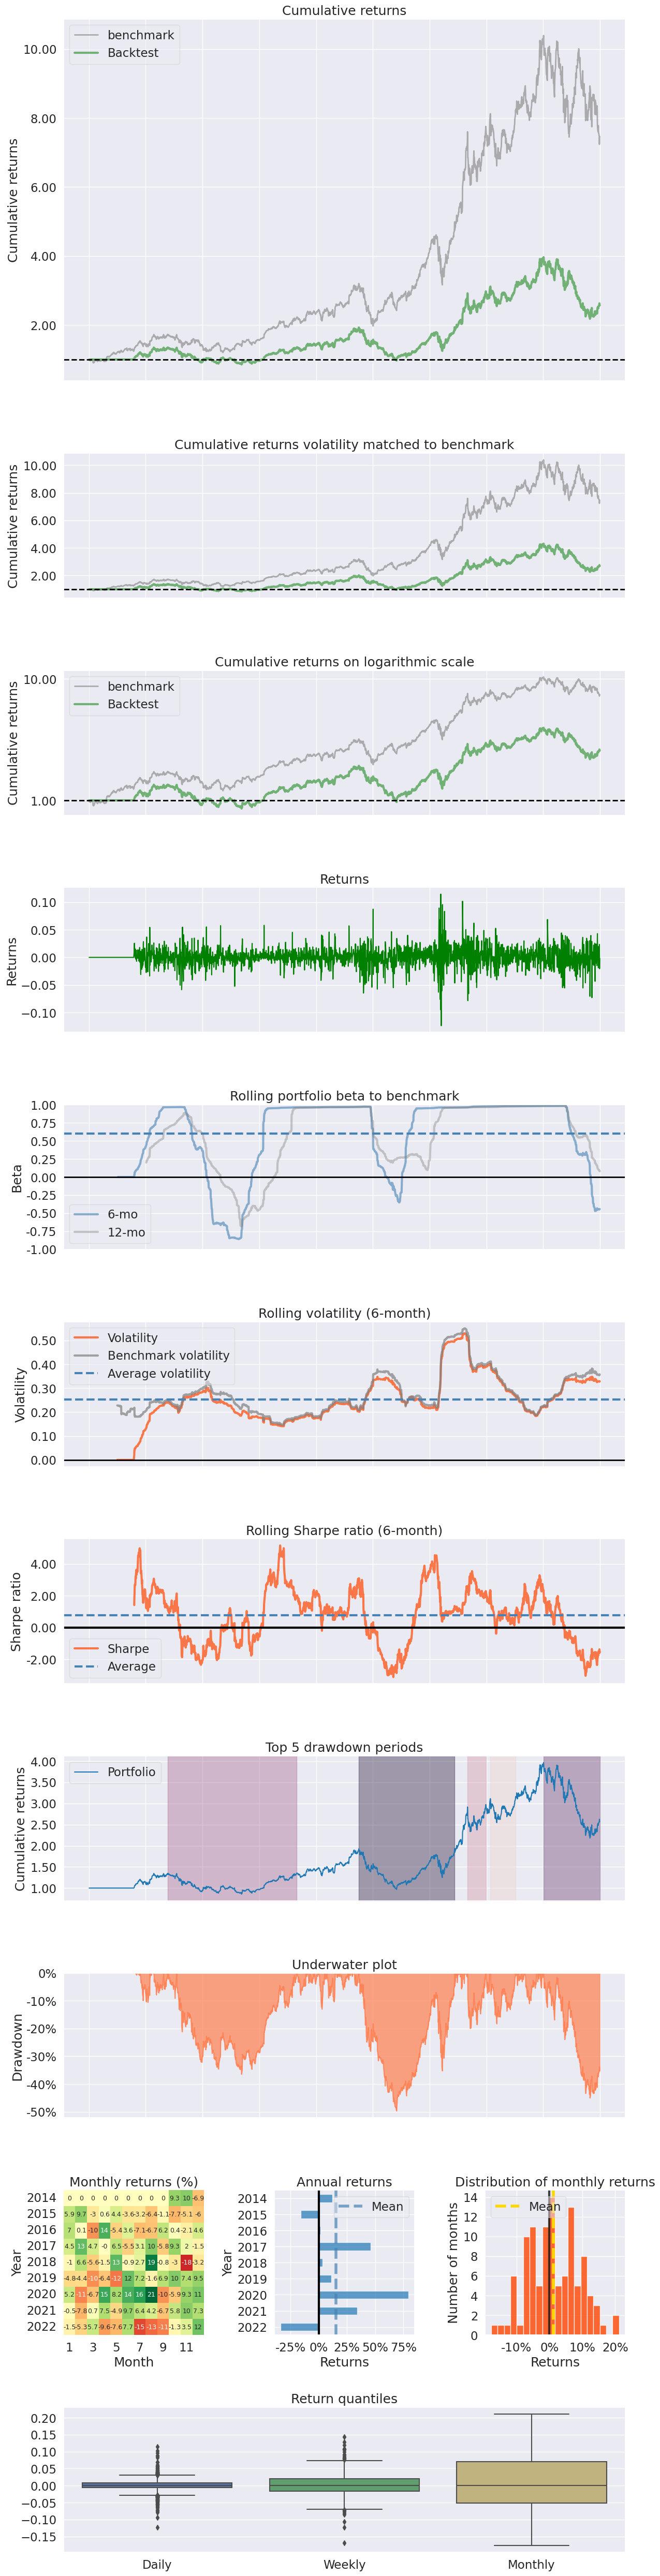

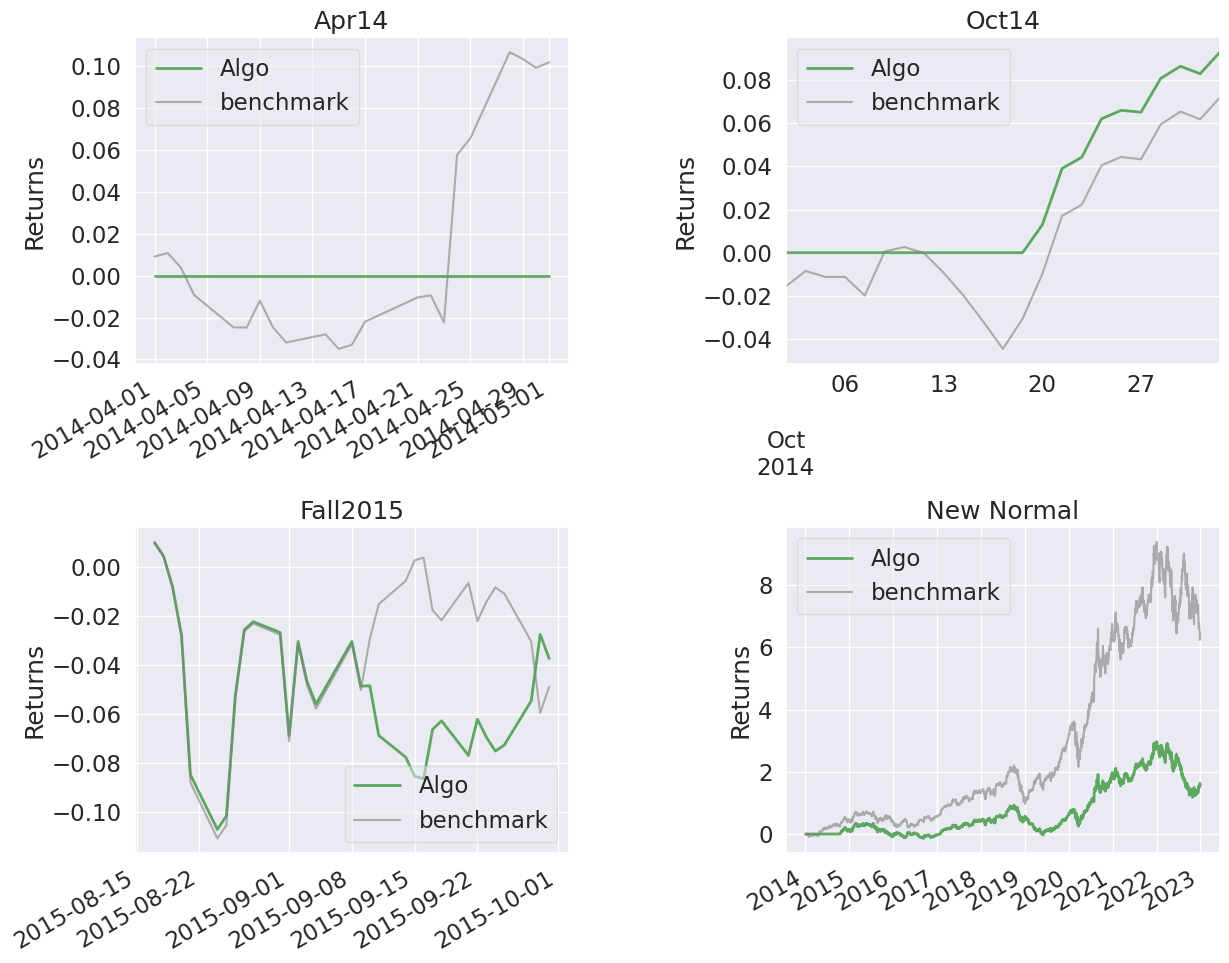

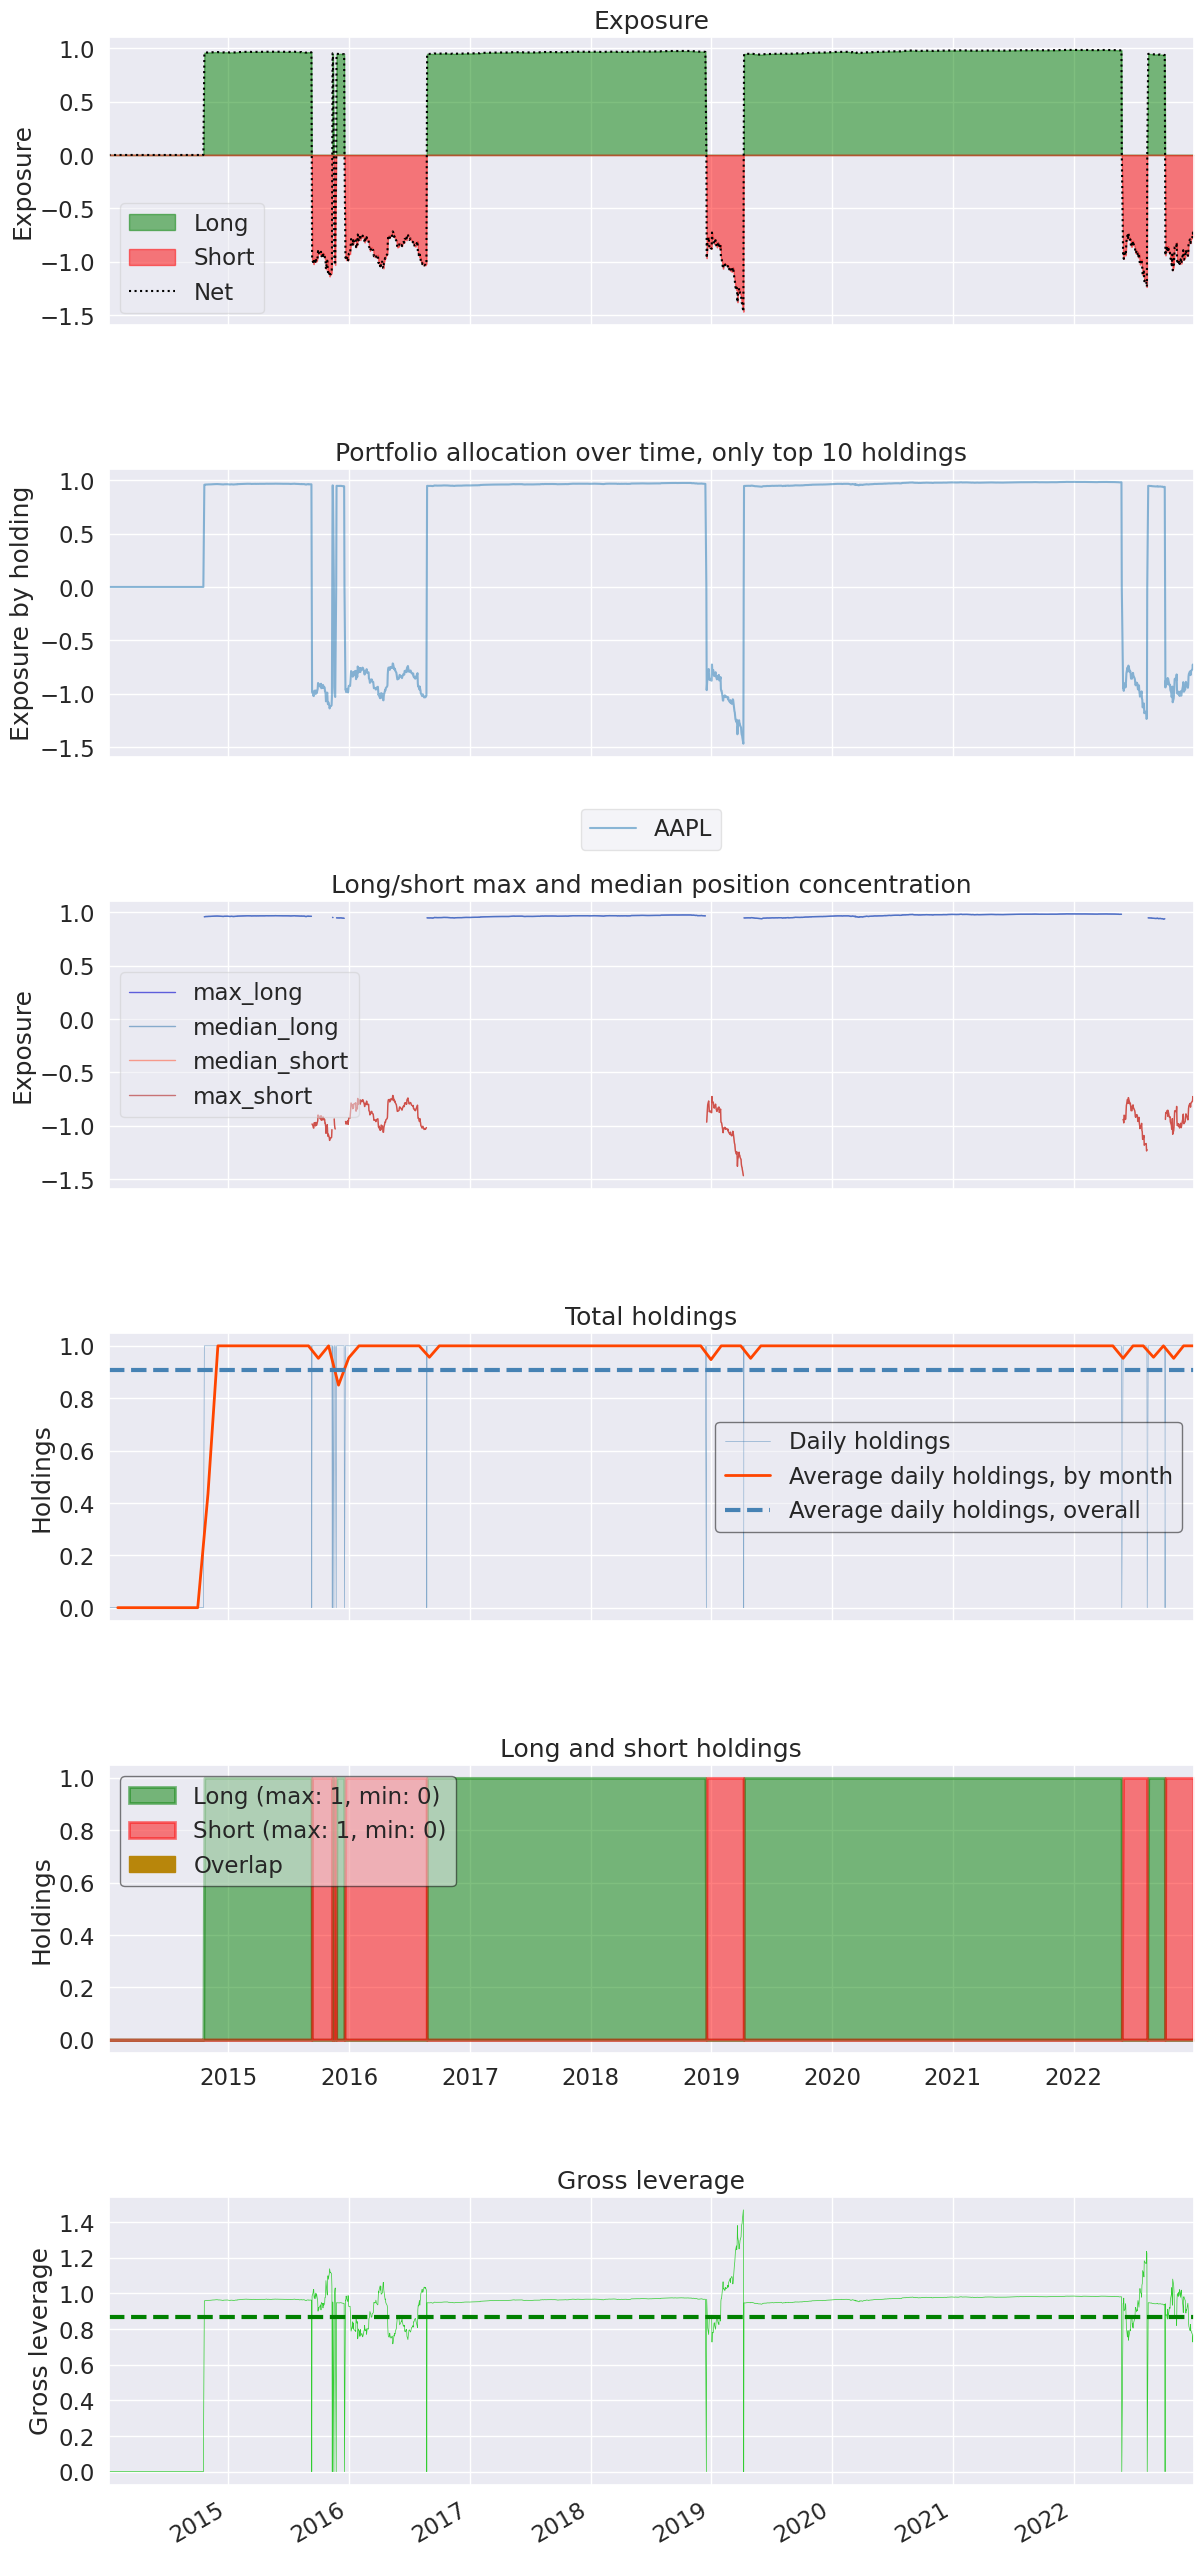

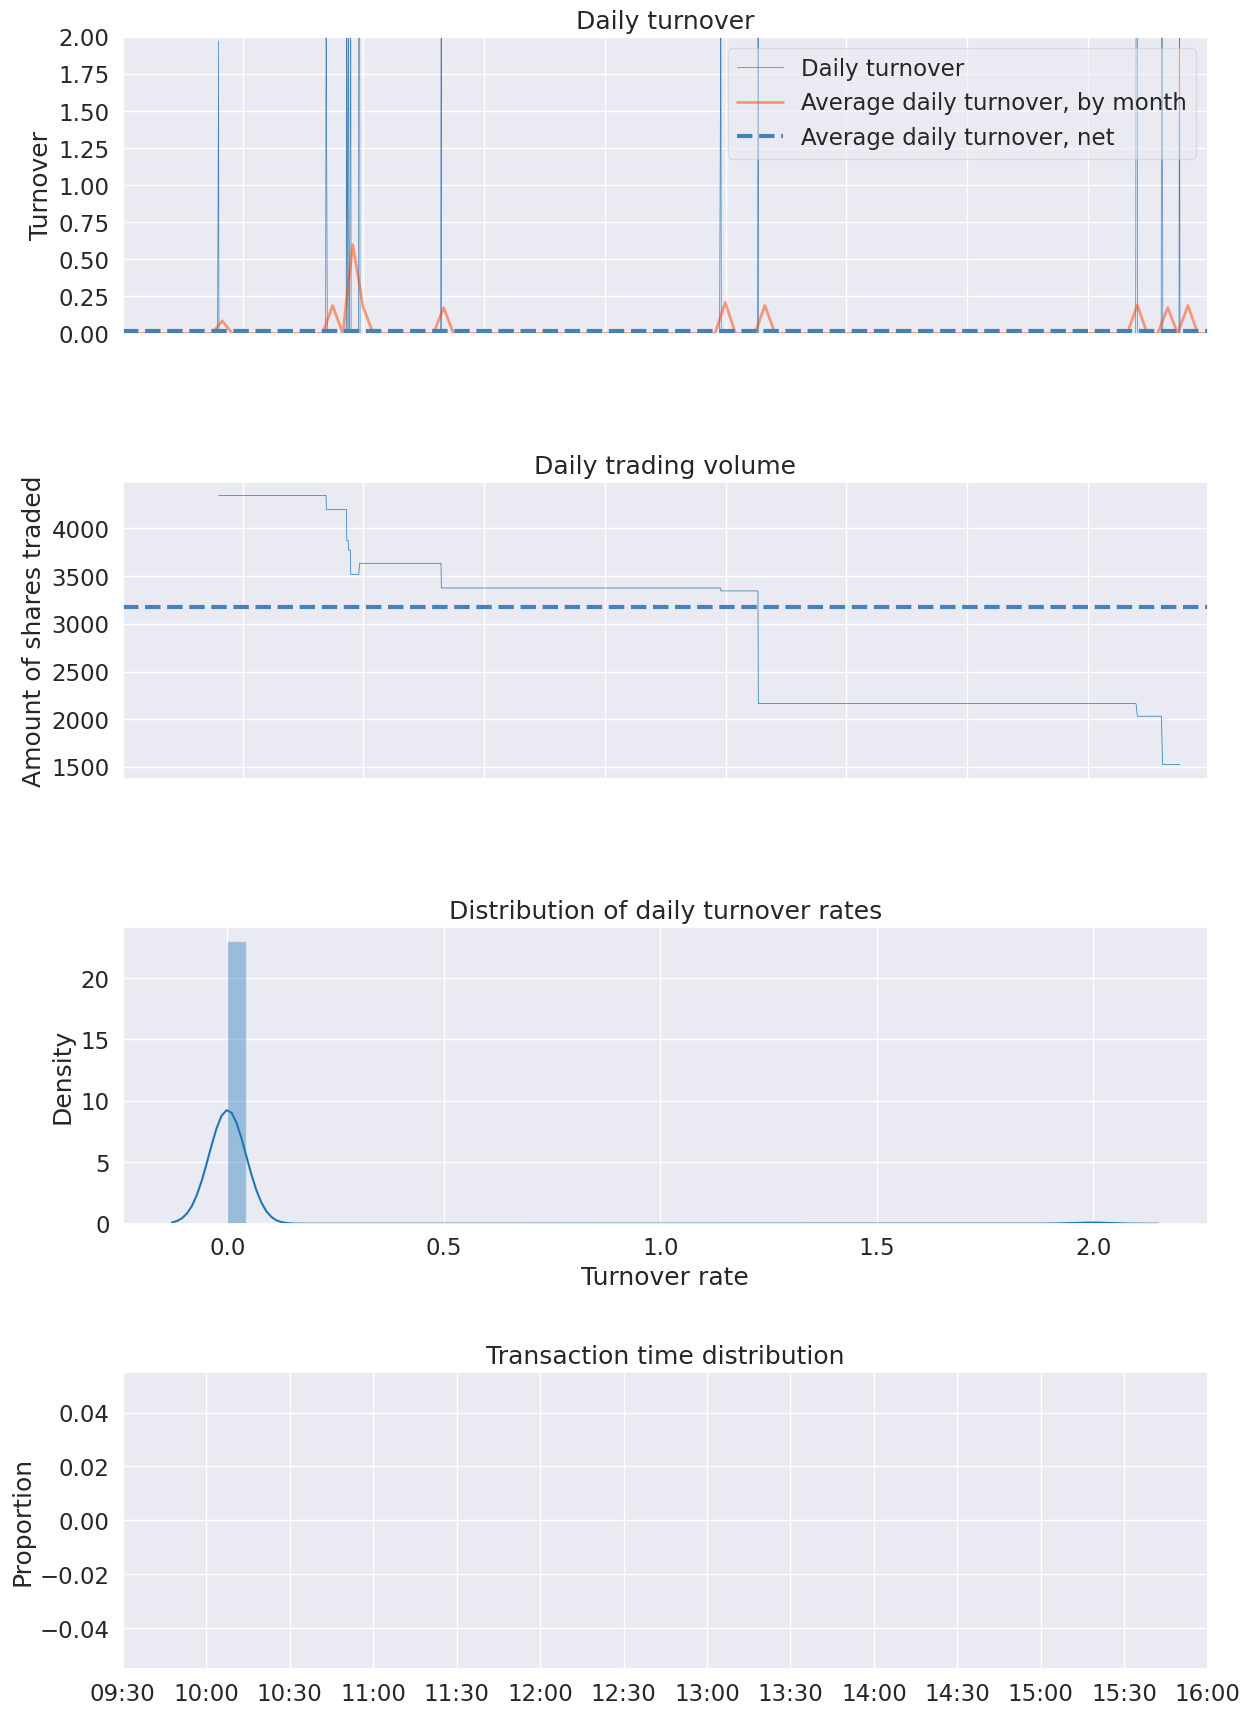

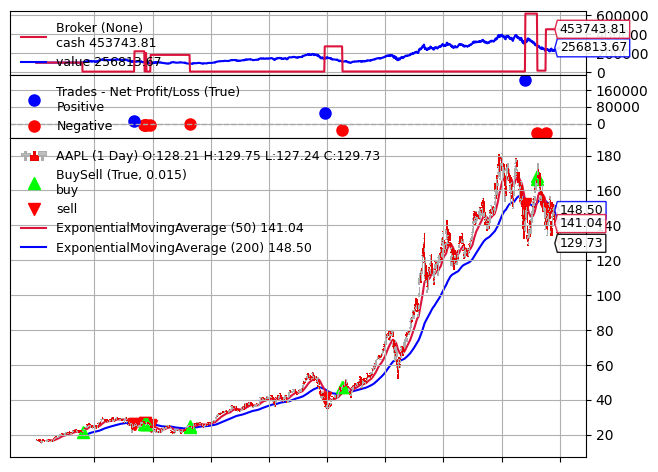

[[<Figure size 640x480 with 3 Axes>]]

In [ ]:
import matplotlib.pyplot as plt
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
cerebro.plot(iplot=False, volume=False, width=20)

### References

https://www.backtrader.com/docu/
